# Second attempt to build NN based on 1589 data points from vx variations

## Importing data

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
from torch.utils.data import Dataset
from collections import OrderedDict
import os
import matplotlib.pyplot as plt

# # Hyperparameter tuning imports
# from ray import tune
# from ray import train
# from ray.train import Checkpoint, get_checkpoint
# from ray.tune.schedulers import ASHAScheduler
# import ray.cloudpickle as cloudpickle

results_dir = r"C:\Users\Admin\Documents\Alexander\ANSYS learning\test_results\Unified_vx_var\results"
data_file = os.path.join(results_dir, 'res_vec.npz')
loaded_data = np.load(data_file)['arr_0']
label_file = os.path.join(results_dir, 'res_idx.npy')
labels_array = np.load(label_file)

# Get parameters for normalization:
data_means = torch.from_numpy(np.array([np.mean(loaded_data[:, i]) for i in range(0, loaded_data.shape[1])]))
data_vars = torch.from_numpy(np.array([np.var(loaded_data[:, i]) if np.var(loaded_data[:, i]) != 0 else 1 for i in range(0, loaded_data.shape[1])]))
x_data = torch.from_numpy(loaded_data)

print('Data tensor shape: {}'.format(x_data.shape))
print(f"Datatype of tensor: {x_data.dtype}")
if torch.cuda.is_available():
  x_data = x_data.to('cuda')
print(f"Device tensor is stored on: {x_data.device}")

training_set_prop = 0.8
test_set_prop = 1 - training_set_prop
# index splitting loaded data valid only if data saved in random order. We randomize just in case
final_training_set_index = int(training_set_prop * len(x_data))
training_data = x_data[0:final_training_set_index, :]
test_data = x_data[final_training_set_index:, :]

training_data.requires_grad = True
test_data.requires_grad = True


class CustomConvectionDataset(Dataset):
    def __init__(self, label_file, data_tensor, data_means, data_vars, transform=None, target_transform=None):
        self.labels = np.load(label_file)
        self.output_data_positions = np.char.startswith(self.labels, 'h')
        self.input_data_positions = ~ self.output_data_positions
        self.data = data_tensor
        self.data_means = data_means
        self.data_vars = data_vars
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        if self.transform:
            data_row = self.transform(self.data[idx, :], self.data_means, self.data_vars)
        else:
            data_row = self.data[idx, :]
        input_data = data_row[self.input_data_positions]
        results_data = data_row[self.output_data_positions]
        return input_data.float(), results_data.float()

def input_transf(dataset_row, data_means, data_vars):
    # Given a row of data from the dataset, perform: (x - mean) / var
    return torch.div(torch.sub(dataset_row, data_means), data_vars)

def output_transf(dataset_row, data_means, data_vars):
	# Given a row of data from the dataset, perform: y * var + mean -> reverse of input_transf
	return torch.sub(torch.mul(dataset_row, data_vars), data_means)

def nn_output_transf(nn_output, data_means, data_vars):
	# Given the output of the NN, perform: y * var + mean -> reverse of input_transf on output data
	mask = np.char.startswith(labels_array, 'h')  # Boolean mask for labels that start with an 'h'
	filtered_data_means = data_means[torch.tensor(mask)]
	filtered_data_vars = data_vars[torch.tensor(mask)]
	return torch.sub(torch.mul(nn_output, filtered_data_vars), filtered_data_means)
    
TrainingDataset = CustomConvectionDataset(label_file=label_file, data_tensor=training_data, data_means=data_means, data_vars=data_vars, transform=input_transf)
TestingDataset = CustomConvectionDataset(label_file=label_file, data_tensor=test_data, data_means=data_means, data_vars=data_vars, transform=input_transf)

print(len(TrainingDataset))
print(TrainingDataset.__getitem__(40))

Data tensor shape: torch.Size([1589, 25])
Datatype of tensor: torch.float64
Device tensor is stored on: cpu
25
(tensor([0.0000, 0.7264, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], grad_fn=<ToCopyBackward0>), tensor([0.0574, 0.0284, 0.0343, 0.0343, 0.0482, 0.1328, 0.0894, 0.0943, 0.0764,
        0.0777, 0.0644, 0.0621, 0.0635], grad_fn=<ToCopyBackward0>))


## Defining a Dataloader: Good for shuffling between epochs etc.

In [2]:
batch_size = 5

# Create data loaders.
train_dataloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TestingDataset, batch_size=batch_size, shuffle=True)

# Display data for a given param
train_data_row = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")


## Defining the Neural Network architecture

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, network_arch):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(network_arch)

    def forward(self, x):
        fwd_pass_steps_in_order = self.linear_relu_stack(x)
        return fwd_pass_steps_in_order

num_n_input_layer = 12
num_n_intermediate_layer = 20
num_n_output_layer = 13
network_arch = OrderedDict([
	('lin1', nn.Linear(num_n_input_layer, num_n_intermediate_layer)),
	('relu1', nn.Tanh()),
	('lin2', nn.Linear(num_n_intermediate_layer, num_n_output_layer)),
	# ('relu2', nn.ReLU()),
	])

model = NeuralNetwork(network_arch=network_arch).to(device)
print(model)
print(model.parameters())
print(sum([len(m) for m in list(model.parameters())]))

print('testing:')
input = torch.randn(num_n_input_layer)
print(input.shape)
print(model(input))

Using cpu device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (lin1): Linear(in_features=12, out_features=20, bias=True)
    (relu1): Tanh()
    (lin2): Linear(in_features=20, out_features=13, bias=True)
  )
)
<generator object Module.parameters at 0x000002831F7AE180>
66
testing:
torch.Size([12])
tensor([-0.2407, -0.3078,  0.2663,  0.1121, -0.2061,  0.1644,  0.1972, -0.1798,
         0.1432,  0.3078, -0.4879,  0.3393, -0.1794], grad_fn=<ViewBackward0>)


## Training and testing function definition

In [ ]:
# To train a model, we need a loss function and an optimizer.
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

def train(dataloader, model, loss_fn, optimizer, printer=False):
    size = len(dataloader.dataset)
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        # Note that X is the NN input vector, y is the correct result for the given input X
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()  # computes gradient of loss function
        optimizer.step()
        optimizer.zero_grad()

        if batch_idx+1 % 5 == 0 and printer:
            loss, current = loss.item(), (batch_idx + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

# Check the models performance to see that it is learning
def test(dataloader, model, loss_fn, printer=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy = torch.nn.functional.mse_loss(pred, y, reduce='mean')  # element-wise mean squared error
    test_loss /= num_batches
    accuracy /= size
    if printer:
        print(f"Test Error: \n L2 loss: {(accuracy):>0.1f}, Avg loss: {test_loss:>8f} \n")
    return test_loss, accuracy


## Training and testing through n Epochs

c:\Users\Admin\Documents\Alexander\Python\.venv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Done!


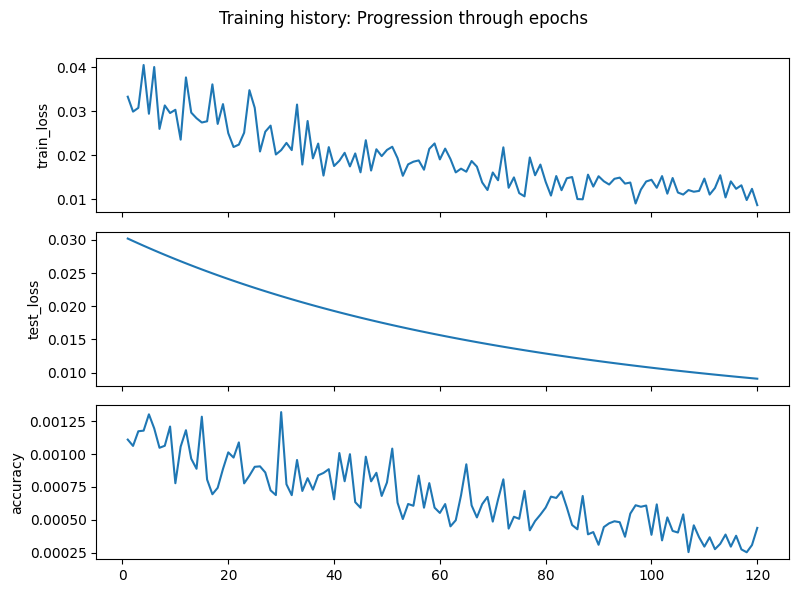

In [5]:
import matplotlib.pyplot as plt
history = {
    'train_loss': [],
	'test_loss': [],
	'accuracy': [],
}

epochs = 120
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
    # Save training progress to historical sequence
    history['train_loss'].append(float(train_loss))
    history['test_loss'].append(float(test_loss))
    history['accuracy'].append(float(test_accuracy))

print("Done!")

# Create the figure and subplots
n_subplots = 3
epoch_axis_data = list(range(1, epochs+1))
fig, axs = plt.subplots(n_subplots, 1, sharex=True, figsize=(8, 6))
for idx, (label, history) in zip(range(n_subplots), history.items()):
    axs[idx].plot(epoch_axis_data, history)
    axs[idx].set_ylabel(label)

fig.suptitle('Training history: Progression through epochs')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Saving the model

In [6]:
model_path = os.path.join(results_dir, "model.pth")
torch.save(model.state_dict(), model_path)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading models and making predictions:

In [7]:
model = NeuralNetwork(network_arch=network_arch).to(device)
model.load_state_dict(torch.load(model_path, weights_only=True))

model.eval()
x, y = TrainingDataset.__getitem__(40)
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    print(f'Predicted: "{pred}", Actual: "{y}"')
    print('total_error: ')

Predicted: "tensor([ 0.0889, -0.0519,  0.0769, -0.0120,  0.1143, -0.0167,  0.0517, -0.0420,
        -0.1605,  0.0852,  0.0839,  0.0458,  0.1458])", Actual: "tensor([0.0574, 0.0284, 0.0343, 0.0343, 0.0482, 0.1328, 0.0894, 0.0943, 0.0764,
        0.0777, 0.0644, 0.0621, 0.0635], grad_fn=<ToCopyBackward0>)"
total_error: 
